## Hypothesis

In "Mind Your Outliers! Investigating the Negative Impact of Outliers on Active Learning for Visual Question Answering", Karamcheti et al. point out that removing the most confused samples from the training dataset, often leads to better performance and models that can be trained longer without incurring in overfitting.

Could this improve the performance of our classifier?

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd

df = pd.read_csv("../data/train_folds.csv")
df.head()

,Unnamed: 0,Unnamed: 0.1,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,kfold,ignore
0,0,0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63,0,0
1,1,1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42,2,0
2,2,2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28,3,0
3,3,3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15,3,1
4,4,4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72,1,0


In [3]:
from pathlib import Path

test_image_fpaths = [Path(f"../data/train/{i}.jpg") for i in df["Id"].values.tolist()]
test_image_fpaths[:5]

[PosixPath('../data/train/0007de18844b0dbbb5e1f607da0606e0.jpg'),
 PosixPath('../data/train/0009c66b9439883ba2750fb825e1d7db.jpg'),
 PosixPath('../data/train/0013fd999caf9a3efe1352ca1b0d937e.jpg'),
 PosixPath('../data/train/0018df346ac9c1d8413cfcc888ca8246.jpg'),
 PosixPath('../data/train/001dc955e10590d3ca4673f034feeef2.jpg')]

In [4]:
test_targets = [[t] for t in df.Pawpularity.values.tolist()]
test_targets[:5]

[[63], [42], [28], [15], [72]]

In [5]:
from ml.vision.data import ImageDataModule
from timm.data import transforms_factory

In [6]:
train_aug = transforms_factory.create_transform(
    input_size=224,
    is_training=True,
    auto_augment='rand-n2-m10',
)
val_aug = transforms_factory.create_transform(
    input_size=224,
    is_training=False
)

In [7]:
from omegaconf import OmegaConf
from ml.params import load_cfg

cfg = load_cfg('../params.yaml', cfg_name=f"train_two")
cfg = OmegaConf.create(cfg)
cfg.bs = 16
cfg

{'name': 'two', 'seed': 7591, 'n_folds': 5, 'fold': -1, 'metric': 'rmse', 'metric_mode': 'min', 'train_data': 'data/train', 'arch': 'swin_large_patch4_window7_224', 'pretrained': True, 'epochs': 6, 'bs': 16, 'auto_batch_size': False, 'accumulate_grad_batches': 1, 'precision': 'bf16', 'use_normalize': True, 'n_tfms': 1, 'magn': 5, 'sz': 224, 'use_mix': 0, 'mix_p': 0.0, 'resize': -1, 'dropout': 0.0, 'wd': 0.0, 'label_smoothing': 0.1, 'loss': 'bce_with_logits', 'opt': 'adamw', 'sched': 'cosine', 'warmup_epochs': 1, 'lr': 5e-05, 'auto_lr': False, 'mom': 0.9}

In [8]:
from ml.learner import ImageClassifier

ckpt_fpaths = [f"../ckpts/model_{cfg.name}_fold0.ckpt"]
model = ImageClassifier(cfg=cfg, in_channels=3, num_classes=1)

/opt/conda/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:2156.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/opt/conda/lib/python3.8/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [9]:
import torch
import pytorch_lightning as pl

print(f"Generating predictions using model {cfg.name}...")
for idx, ckpt_fpath in enumerate(ckpt_fpaths):
    ckpt = torch.load(ckpt_fpath)
    model.load_state_dict(ckpt["state_dict"])

    dm = ImageDataModule(
        task="classification",
        batch_size=32,
        test_image_paths=test_image_fpaths,
        test_augmentations=val_aug
    )
    dm.setup()    
    
    trainer = pl.Trainer(gpus=1)
    preds = trainer.predict(model, dm.test_dataloader())

Generating predictions using model two...


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

## Find most confused samples

In [10]:
import numpy as np

y_true = np.array(test_targets)
y_pred = np.vstack(preds) * 100

In [11]:
y_diff = np.abs(y_true - y_pred)

In [12]:
y_diff

array([[13.6140213 ],
       [ 2.43737793],
       [ 9.78923035],
       ...,
       [ 5.78013611],
       [15.09918594],
       [ 1.33034134]])

In [13]:
y_diff[np.argsort(y_diff.squeeze())]

array([[1.08337402e-03],
       [1.24359131e-03],
       [1.77383423e-03],
       ...,
       [8.06209335e+01],
       [8.10966568e+01],
       [8.74400711e+01]])

In [14]:
sorted_indexes = np.argsort(y_diff.squeeze())
sorted_y_diff = y_diff[sorted_indexes]
sorted_y_diff[5:]

array([[5.64193726e-03],
       [5.93566895e-03],
       [7.16018677e-03],
       ...,
       [8.06209335e+01],
       [8.10966568e+01],
       [8.74400711e+01]])

These last 3 predictions have an absolute error of 75 percentage points! Our model is widely off.

/opt/conda/lib/python3.8/site-packages/matplotlib/__init__.py:152: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
/opt/conda/lib/python3.8/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/opt/conda/lib/python3.8/site-packages/matplotlib/__init__.py:152: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
/opt/conda/lib/python3.8/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/opt/conda/lib/python3.8/site-packages/matplotlib/__init__.py:152: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module

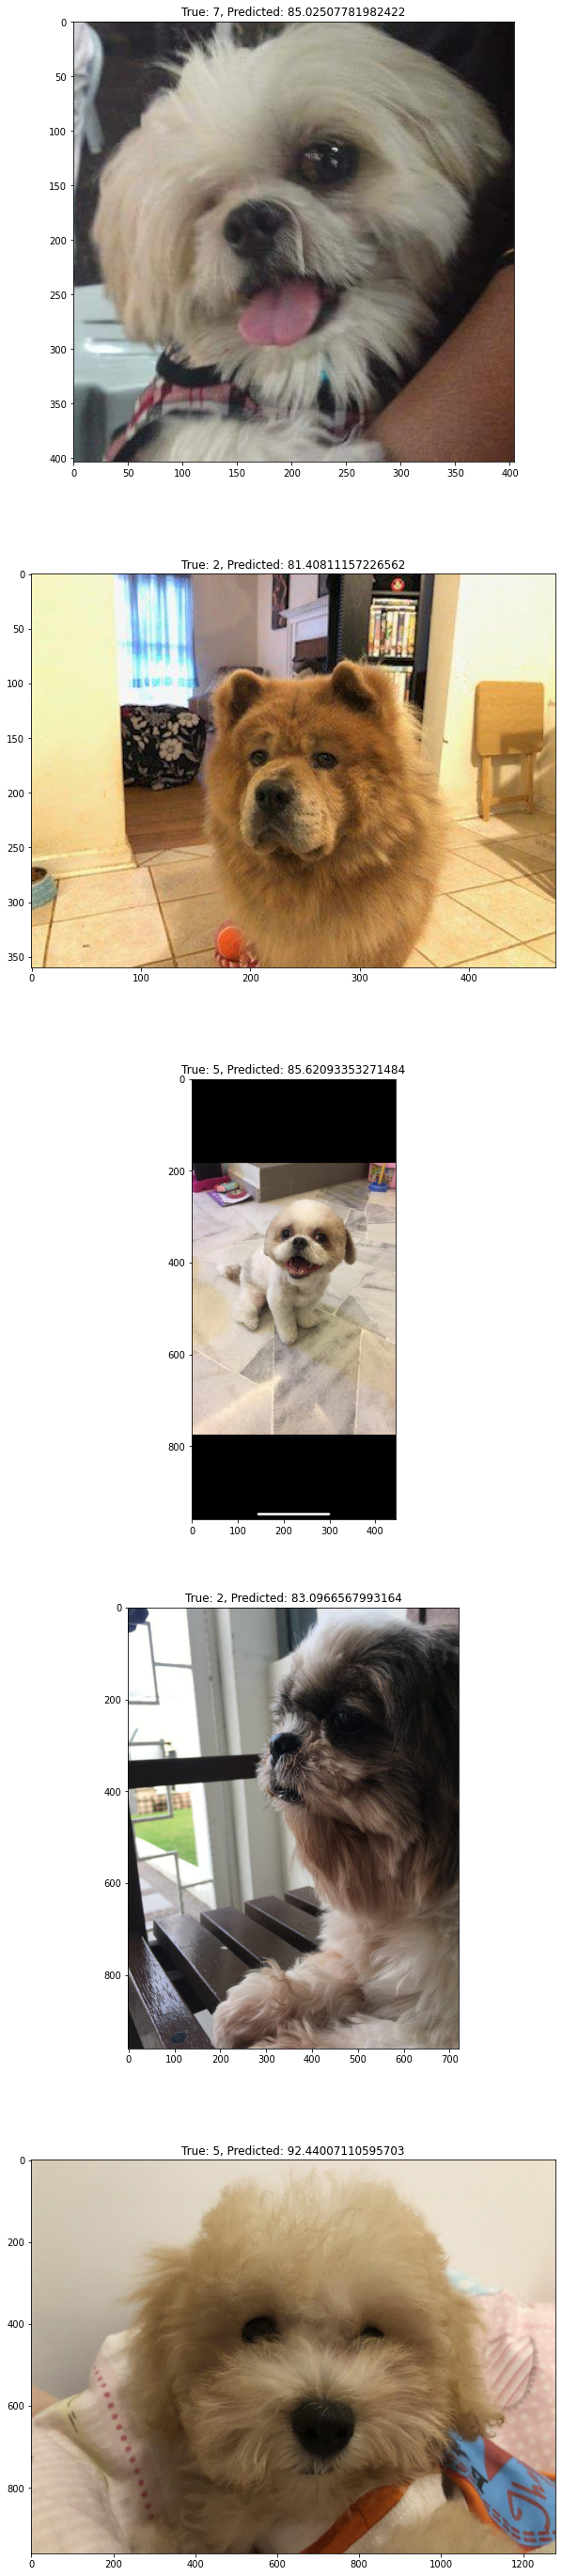

In [15]:
import matplotlib.pyplot as plt
from PIL import Image

n_samples = 5

hardest_samples = sorted_indexes[-n_samples:]

fig, axs = plt.subplots(nrows=n_samples, ncols=1, figsize=(10, n_samples*10))
for i, idx in enumerate(hardest_samples):
    axs[i].imshow(Image.open(test_image_fpaths[idx]))
    axs[i].set_title(f"True: {test_targets[idx][0]}, Predicted: {y_pred[idx][0]}")

## Remove hardest to classify samples from training dataset

In [16]:
to_keep = int(len(sorted_indexes)*0.9)

In [17]:
df["pred"] = y_pred
df["hard_index"] = sorted_indexes.argsort()
df["ignore"] = np.where(df["hard_index"] > to_keep, 1, 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,kfold,ignore,pred,hard_index
0,0,0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63,0,0,49.385979,7182
1,1,1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42,2,0,39.562622,1681
2,2,2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28,3,0,37.789230,5901
3,3,3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15,3,1,60.693371,9607
4,4,4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72,1,0,51.855534,8352


In [18]:
df[df.ignore==0].hard_index.mean()

4443.5

In [19]:
df.groupby("kfold").Pawpularity.agg(["mean", "count"])

,mean,count
kfold,,
0,38.047089,1975
1,38.026835,1975
2,38.083038,1975
3,38.067342,1975
4,38.066329,1975


In [20]:
df[df.ignore==0].groupby("kfold").Pawpularity.agg(["mean", "count"])

,mean,count
kfold,,
0,35.489192,1758
1,35.817318,1790
2,36.234270,1780
3,35.882913,1785
4,35.917746,1775


## Retrain model without hardest samples

In [21]:
df2 = df[df.ignore==0]

train_image_fpaths = [Path(f"../data/train/{i}.jpg") for i in df2[df2.kfold!=0]["Id"].values.tolist()]
train_targets = [[t/100.] for t in df2[df2.kfold!=0].Pawpularity.values.tolist()]

Note that we are keeping the hard to classify samples in the validation set.

In [22]:
val_image_fpaths = [Path(f"../data/train/{i}.jpg") for i in df[df.kfold==0]["Id"].values.tolist()]
val_targets = [[t/100.] for t in df[df.kfold==0].Pawpularity.values.tolist()]

In [23]:
dm = ImageDataModule(
    task="classification",
    batch_size=16,
    # train
    train_image_paths=train_image_fpaths,
    train_augmentations=train_aug,
    train_targets=train_targets,
    # valid
    val_image_paths=val_image_fpaths,
    val_augmentations=val_aug,
    val_targets=val_targets,    
)
dm.setup()    

In [24]:
cfg = load_cfg(fpath="../params.yaml", cfg_name=f"train_two")

In [25]:
model = ImageClassifier(
    in_channels=3,
    num_classes=1,
    cfg=cfg,
    pretrained=True
)

/opt/conda/lib/python3.8/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [26]:
trainer = pl.Trainer(
    gpus=1,
    precision=16,
    max_epochs=cfg.epochs,
)

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [27]:
trainer.fit(model, dm)

/opt/conda/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
/opt/conda/lib/python3.8/site-packages/pytorch_lightning/utilities/model_summary.py:431: UserWarning: A layer with UninitializedParameter was found. Thus, the total number of parameters detected may be inaccurate.
  warning_cache.warn(

  | Name         | Type                 | Params
------------------------------------------------------
0 | backbone     | SwinTransformer      | 194 M 
1 | head         | Sequential           | 8.3 K 
2 | train_metric | RootMeanSquaredError | 0     
3 | val_metric   | RootMeanSquaredError | 0     
------------------------------------------------------
195 M     Trainable params
0         Non-trainable params
195 M     Total params
390.008  

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 7.93 GiB total capacity; 6.71 GiB already allocated; 5.75 MiB free; 7.06 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF